# Import Libraries

In [3]:
from __future__ import division
import numpy as np
import pandas as pd
import random, datetime, calendar
import csv
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import sys
hydropath = "C:/Users/Hutto/PycharmProjects/hydromix"
sys.path.append(hydropath)
import hydromix
from hydromix.mixingfunctions import *

The first case study demonstrates the ability of HydroMix to converge on the correct posterior distribution for synthetically generated data. The second case study uses a synthetic dataset of rain, snow, and groundwater isotopic ratios using a conceptual hydrologic model and compares the results of HydroMix to the actual mixing ratios assumed to generate the dataset. It then weights the source samples and evaluates the effect of weighting on the mixing ratio (case study in Sect. 3.3). In the last two case studies, HydroMix is applied to observed tracer data from an Alpine catchment in the Swiss Alps to infer source mixing ratios and an additional parameter (isotopic lapse rate).

# GW_Conceptual

* Created on: 5th October 2018 (Harsh Beria)
* Last updated on: 22th November 2018 (Put the mixing part in another script GW_mixing_HydroMix.py)
* Last updated on: 21st December 2018 (Plots figure for snowfall vs snowmelt isotopic ratios)
* Creates synthetic time series of rain and snow isotopic ratio, & simulates isotopic ratio in groundwater
* Makes boxplots of isotopic ratio of snowfall vs snowmelt
* OutputFiles processed: OutputFiles/GW_conceptual/
* Figures made: OutputFiles/GW_conceptual/SF_SM_boxplot.jpeg

## Set up parameters

In [5]:
# Percentage of rain and snow recharging groundwater

RAIN_EFF = 1. 
SNOW_EFF = 1.
K_Q = 0.1  # For Q = KS
DEGDAYFACT = 2.5  # Degree day factor in mm/C/day
TMELT = 0.  # Temperature at which snowpack starts melting
const_storage = 1000. 
init_snow = 0.  # Constant storage in groundwater which is not fed to streamflow and initial snow height in catchment
varLSnowTemp = -1. 
varHSnowTemp = 1.  # Threshold temperature for bounding thresholding method for snowfall estimation

# Parameters for generation of air temperature, precipitation and precipitation isotopic ratio
YEARS = 100  # Number of years for which simulation is carried out
AirTempMean = 4. 
AirTempAmpl = 8.
PrecipEventNumb = 30
PrecipMean = 1000.
PrecipIsoMean = -80.
PrecipIsoAmpl = 40.

# To save records into a csv file
FINAL_LIS = [["Day number", "Rainfall (mm)", "Snowfall (mm)", 
              "Storage (mm)", "Snowmelt (mm)", "Snowheight (mm)",
              "Q from GW (mm)",
              "Rain recharge (mm)", "Snow recharge (mm)", 
              "Precip isotopic ratio", "Snowpack isotopic ratio",
              "Storage isotopic ratio"]]
snowMeltIso = []  # For storing snowmelt isotopic ratios
outputpath = hydropath + "/OutputFiles/GW_conceptual/"

# Mixing model parameters
NUMBER_ITERATIONS = 1000
LAMBDA_RANGE = [0., 1.]  # LAMBDA values imply the fraction of snow in groundwater
# Number of best simulations using which lambda is computed
BEST_SIM_PER = 5.  # In percentage

LAST_YEARS = 1  # Number of years at the end of the timeseries from which isotopic data is sampled

np.random.seed(15544)  # Setting up a common seed number
random.seed(55452)  # Setting up random seed for the random function

## Time series of air temperature, precipitation and isotopic ratio of precipitation

In [6]:
# %% Time series of air temperature, precipitation and isotopic ratio of precipitation
airTemp = air_temp_gen(mean_temp=AirTempMean, ampl_temp=AirTempAmpl, years=YEARS)
prcp = poisson_prcp(numb_event=PrecipEventNumb, mean_prcp=PrecipMean, years=YEARS)
prcpIso = prcp_iso(mean_iso=PrecipIsoMean, ampl_iso=PrecipIsoAmpl, years=YEARS)
dayNumb = np.linspace(1, 365 * YEARS, 365 * YEARS)  # Day numbering

## Running the hydrologic model

In [8]:
# %% Running the hydrologic model
storage = [const_storage]  # Catchment storage
snow_height = [init_snow]  # Snow height
snow_melt = [0.]  # Snow melt
storage_C = [0.]  # Isotopic ratio in catchment storage (groundwater)
snow_C = [0.]  # Isotopic ratio in snowpack
rain_lis = [0.]
snow_lis = [0.]  # Daily rainfall and snowfall amount
recharge_rain_lis = [0.]
recharge_snow_lis = [0.]  # Daily groundwater recharge values from rainfall and snowmelt
Q_flow = [0.]  # Daily flow into the stream from groundwater

for index in range(len(dayNumb)):

    # Estimating amount of rain and snow
    if airTemp[index] <= varLSnowTemp:
        rain_frac = 0.
    elif airTemp[index] >= varHSnowTemp:
        rain_frac = 1.
    else:
        rain_frac = (airTemp[index] - varLSnowTemp) * 1. / (varHSnowTemp - varLSnowTemp)
    rain_mag = rain_frac * prcp[index] * 1.
    snow_mag = (1 - rain_frac) * prcp[index] * 1.
    rain_lis.append(rain_mag)
    snow_lis.append(snow_mag)

    # Computing snow height and snowmelt volume
    if airTemp[index] >= TMELT:
        melt = DEGDAYFACT * (airTemp[index] - TMELT)
        if melt > snow_height[-1]:  # Applying limit of available storage
            melt = snow_height[-1] + snow_lis[-1]
    else:
        melt = 0.
    snow_height.append(snow_height[-1] + snow_lis[-1] - melt)
    snow_melt.append(melt)

    # Isotopic ratio of snowpack
    if snow_height[-1] == 0.:  # No more snowpack left
        newC = 0.
    else:
        newC = (snow_height[-2] * snow_C[-1] + snow_lis[-1] * prcpIso[index] - melt * snow_C[-1]) * 1. / (
                snow_height[-2] + snow_lis[-1] - melt)
        snowMeltIso.append(newC)
    snow_C.append(newC)

    # Computing groundwater recharge from rain and snow
    recharge_rain, recharge_snow = rain_lis[-1] * RAIN_EFF * 1., snow_melt[-1] * SNOW_EFF * 1.
    recharge_rain_lis.append(recharge_rain)
    recharge_snow_lis.append(recharge_snow)

    recharge = recharge_rain + recharge_snow
    storage.append(storage[-1] + recharge)
    Q = K_Q * (storage[-1] - const_storage)  # Flow into streamflow from groundwater
    storage[-1] -= Q  # Updating groundwater volume
    Q_flow.append(Q)

    # Isotopic ratio of groundwater storage
    if round(storage[-1], 2) == 0.:
        newC = 0.
    else:
        newC = (storage[-2] * storage_C[-1] + rain_lis[-1] * RAIN_EFF * prcpIso[index] + snow_melt[-1] * SNOW_EFF *
                snow_C[-2] - Q * storage_C[-1]) * 1. / (
                       storage[-2] + rain_lis[-1] * RAIN_EFF + snow_melt[-1] * SNOW_EFF - Q)
    storage_C.append(newC)

    FINAL_LIS.append(
        [dayNumb[index], rain_lis[-1], snow_lis[-1], storage[-1], snow_melt[-1], snow_height[-1], Q_flow[-1],
         recharge_rain_lis[-1], recharge_snow_lis[-1], prcpIso[index], snow_C[-1], storage_C[-1]])


## Saving the simulated data into a csv file

In [9]:
path = f"{outputpath}RAIN_{RAIN_EFF:0.1f}_SNOW_{SNOW_EFF:0.1f}.csv"
csv_writer(FINAL_LIS, path)
print(path)

C:/Users/Hutto/PycharmProjects/hydromix/OutputFiles/GW_conceptual/RAIN_1.0_SNOW_1.0.csv


## Plotting boxplots of snowfall and snowmelt

C:/Users/Hutto/PycharmProjects/hydromix/OutputFiles/GW_conceptual/Figures/SF_SM_boxplot.jpeg


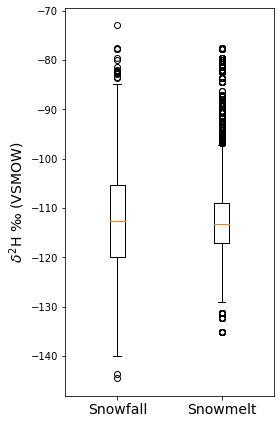

In [10]:
snowFallIso = prcpIso[(prcp > 0.) & (airTemp < (0.5 * (varLSnowTemp + varHSnowTemp)))]  # Snowfall isotopic ratios

matplotlib.rc('xtick', labelsize=14)
plt.figure(figsize=(4, 6))
plt.boxplot([snowFallIso, snowMeltIso], labels=["Snowfall", "Snowmelt"])
plt.ylabel(r'$\delta^{2}$' + 'H ' + u'\u2030' + ' (VSMOW)', fontsize=14)
plt.tight_layout()
path = outputpath + "Figures/SF_SM_boxplot.jpeg"
plt.savefig(path, dpi=300)

print(path)

# GWisoPlot

In [ ]:
"""
Created on: 3rd December 2018 (Harsh Beria)
Last updated on
What it does?

Used for not so important plots

SourceFiles used:
OutputFiles/GW_conceptual/

OutputFiles processed: NONE
Figures made:
OutputFiles/GW_conceptual/Figures/GW_iso_0.3_rain_0.6_snow.jpeg

"""

# Main variables

RAIN_EFF, SNOW_EFF = 0.3, 0.6
PATH = hydropath + "/OutputFiles/GW_conceptual/"

# %% Plotting isotopic ratio in groundwater for the entire simulation period

filename = PATH + "RAIN_" + str(RAIN_EFF) + "_SNOW_" + str(SNOW_EFF) + ".csv"
df = pd.read_csv(filename)
GW_iso = df["Storage isotopic ratio"].values

fig, ax = plt.subplots(1)
ax.plot(GW_iso)

# To display yticks in multiple of 10 years
ax.set_xticks(np.arange(0, 365*100+1, 365*10))
ax.set_xticklabels([year for year in range(0, 101, 10)])

# Setting the labels
ax.set_ylabel("Groundwater " + r'$\delta^{2}$H' + u' \u2030 ', fontsize=14)
ax.set_xlabel("Year number", fontsize=14)

plt.tight_layout()
plt.grid(linestyle='dotted')
figOutput = PATH + "Figures/GW_iso_" + str(RAIN_EFF) + "_rain_" + str(SNOW_EFF) + "_snow.jpeg"
plt.savefig(figOutput, dpi=300)
plt.close()
print(figOutput)



# GW_mixing_HydroMix

* This has been explained in Section 3.2 of the manuscript
* Model run with a given rain and snow recharge efficiency can be made with the script: GW_conceptual.py. This script was run 100 times by varying rain and snow efficiency between 0.1 to 1 in steps of 0.1 and the results are saved in OutputFiles/GW_conceptual/ folder
* An importance sampling and a MCMC sampler has been implemented to solve the mixing problem


In this case study, we build a conceptual hydrologic model wherein groundwater is assumed to be recharged directly from rainfall and snowmelt. Stable isotopes of deuterium (δ2H) are used to see how the isotopic ratio in groundwater evolves under different assumptions of rain and snow recharge efficiencies.

Synthetic time series are generated for precipitation, the isotopic ratio in precipitation, and air temperature at a daily time step. For generating the precipitation time series, the time between two successive precipitation events is assumed to be a Poisson process with the precipitation intensity following an exponential distribution (Botter et al., 2007; Rodriguez-Iturbe et al., 1999). Time series of air temperature and of isotopic ratios in precipitation are obtained by generating an uncorrelated Gaussian process with the mean following a sine function (to emulate a seasonal signal) and with constant variance (Allen et al., 2018; Parton and Logan, 1981). The separation of precipitation into rainfall (Pr) and snowfall (Ps) is done based on a temperature threshold approach (Harpold et al., 2017a), whereby the fraction of rainfall fr(t) at time step t is computed as a function of air temperature T(t).

In [ ]:
"""
Created on: 21st November 2018 (Harsh Beria)
Last updated on
What it does?

Runs HydroMix to estimate snow ratio in groundwater with the isotopic ratios generated by the script GW_conceptual.py
The main feature is that this script can use different time periods during the computation of snow ratio

SourceFiles used:
OutputFiles/GW_conceptual/

OutputFiles processed
Figures made
"""

## Set up Mixing Model Parameters

In [ ]:

# Main variables

rain_eff, snow_eff = 0.1, 0.1

# Mixing model parameters
number_iterations = 500
lambda_range = [0., 1.]  # LAMBDA values imply the fraction of snow in groundwater
# Number of best simulations using which lambda is computed
best_sim_per = 5.  # In percentage

years = 80 # Number of years for which simulation was carried out
last_years = 2  # Number of years at the end of the timeseries from which isotopic data is sampled

# Options are "Snowfall/Snowmelt", tells us which isotopic ratio is to be used to find groundwater recharge using HydroMix
which_snow = "Snowfall"
weighted = 0  # 0 => non-weighted mixing, 1 => weighted mixing

PATH = hydropath + "/OutputFiles/GW_conceptual/"
outputpath = hydropath + f"/OutputFiles/GW_conceptual/Rainfall_{which_snow:0.1f}_mixing_last_{last_years:0.0f}Yr"
if weighted:
    outputpath += "_weighted/"
else:
    outputpath += "/"

#################################################################################################################################
# %% Initializing the seeds
np.random.seed(15544)  # Setting up a common seed number for numpy function
random.seed(55452)  # Setting up random seed for the random function


## Mixing for all the proportions of rain and snow efficiency in recharging groundwater

In [ ]:



while rain_eff <= 1.:
    snow_eff = 0.1
    while snow_eff <= 1.:

        filename = PATH + f"RAIN_{rain_eff:0.1f}_SNOW_{snow_eff:0.1f}.csv"
        df = pd.read_csv(filename)

        # Computing the proportion of groundwater recharged from snow in long term
        recharge_rain_amount = sum(df["Rain recharge (mm)"].values)
        recharge_snow_amount = sum(df["Snow recharge (mm)"].values)
        actual_snow_ratio_long_term = recharge_snow_amount / (recharge_rain_amount + recharge_snow_amount)

        # Computing the proportion of groundwater recharged from snow in short term (corresponding to the isotopic data period)
        recharge_rain_amount = sum(df["Rain recharge (mm)"].values[(years - last_years) * 365:])
        recharge_snow_amount = sum(df["Snow recharge (mm)"].values[(years - last_years) * 365:])
        actual_snow_ratio_short_term = recharge_snow_amount / (recharge_rain_amount + recharge_snow_amount)

        # Building list containing isotopic ratio of rain, snowfall and groundwater
        random_rain_iso, random_snow_iso, random_gw_iso = [], [], []
        random_rain_amount, random_snow_amount = [], []  # Amount of rain and snowmelt corresponding to the isotopic ratio
        for year_index in range(years - last_years, years):
            for month in range(1, 13):

                # Subsetting the dataframe
                startDayNumb = datetime.datetime(2001, month, 1).timetuple().tm_yday
                start_index = year_index * 365 + startDayNumb
                end_index = start_index + calendar.monthrange(2001, month)[1]

                # Rainfall amount and isotopic ratio
                rain_amount = df["Rainfall (mm)"].values[start_index: end_index + 1]  # Amount of rainfall
                rain_isotopic_ratio = df["Precip isotopic ratio"].values[
                                      start_index: end_index + 1]  # Isotopic ratio of rainfall

                # Amount of snowfall or snowmelt
                if (which_snow == "Snowfall"):
                    snow_amount = df["Snowfall (mm)"].values[start_index: end_index + 1]  # Amount of snowfall
                    snow_isotopic_ratio = df["Precip isotopic ratio"].values[
                                          start_index: end_index + 1]  # Snowfall isotopic ratio
                elif (which_snow == "Snowmelt"):
                    snow_amount = df["Snowmelt (mm)"].values[start_index: end_index + 1]  # Amount of snowmelt
                    # Shifted up by 1 row because the current snowmelt isotopic ratio is the snowpack isotopic ratio at the last timestep
                    snow_isotopic_ratio = df["Snowpack isotopic ratio"].values[
                                          start_index - 1: end_index]  # Snowmelt isotopic ratio

                storage_isotopic_ratio = df["Storage isotopic ratio"].values[
                                         start_index: end_index + 1]  # Groundwater isotopic ratio

                # Only considering days when it rained or [snowed or the snow melted]
                rain_index = np.nonzero(rain_amount)[0]  # Day when there was rain
                snow_index = np.nonzero(snow_amount)[0]  # Day when there was snowfall or snowmelt

                # Isotopic ratio of rainfall and snowfall/snowmelt
                rain_Iso, snow_Iso = rain_isotopic_ratio[rain_index], snow_isotopic_ratio[snow_index]
                # Magnitude of rainfall and snowfall/snowmelt
                temp_rain_amount, temp_snow_amount = rain_amount[rain_index], snow_amount[snow_index]

                # Choosing values of rain and snowfall/snowmelt isotopic ratio to be used in HydroMix
                if (len(rain_Iso) != 0):
                    #					# Randomly choose one monthly rainfall sample
                    #					random_rain_iso.append(random.sample(rain_Iso, 1)[0])
                    #					random_rain_amount.append(random.sample(temp_rain_amount)[0])

                    # Choose all the rainfall samples
                    random_rain_iso.extend(rain_Iso)
                    random_rain_amount.extend(temp_rain_amount)

                if (len(snow_Iso) != 0):
                    #					# Randomly choose one monthly snowfall/snowmelt sample
                    #					random_snow_iso.append(random.sample(snow_Iso, 1)[0])
                    #					random_snow_amount.append(random.sample(temp_snow_amount, 1)[0])

                    # Choose all the snowfall/snowmelt samples
                    random_snow_iso.extend(snow_Iso)
                    random_snow_amount.extend(temp_snow_amount)

                # Randomly choose one monthly groundwater sample
                random_gw_iso.append(random.sample(storage_isotopic_ratio, 1)[0])

        # Defining weights for rain and snowfall/snowmelt samples
        random_rain_weight = np.array([i * j for i, j in zip(random_rain_iso, random_rain_amount)]) / sum(
            random_rain_amount + random_snow_amount)
        random_snow_weight = np.array([i * j for i, j in zip(random_snow_iso, random_snow_amount)]) / sum(
            random_rain_amount + random_snow_amount)

        # Running the mixing model
        # Initializing mixing model parameters
        LAMBDA_params = np.random.uniform(lambda_range[0], lambda_range[1], number_iterations)
        # Computing the variance of error from groundwater samples
        LIKELIHOOD_std_params_H2 = np.full(number_iterations, np.std(random_gw_iso, ddof=1))
        if weighted:  # Running HydroMix taking into account weights
            likelihood_h2, lambda_h2, error_std_h2 = hydro_mix_weighted(random_snow_iso, random_snow_weight,
                                                                        random_rain_iso, random_rain_weight,
                                                                        random_gw_iso, LAMBDA_params,
                                                                        LIKELIHOOD_std_params_H2, number_iterations)
        else:
            # Running HydroMix without taking into account weights
            likelihood_h2, lambda_h2, error_std_h2 = hydro_mix(random_snow_iso, random_rain_iso, random_gw_iso,
                                                               LAMBDA_params, LIKELIHOOD_std_params_H2, number_iterations)

        # Writing in a csv file
        final_lis = [["Snow ratio", "Log likelihood", "Error std"]]
        path = outputpath + "results_RAIN_" + str(rain_eff) + "_SNOW_" + str(snow_eff) + ".csv"
        for index in range(0, len(likelihood_h2)):
            final_lis.append([round(lambda_h2[index], 2), round(likelihood_h2[index], 2), round(error_std_h2[index], 2)])
        print(path)

        # Creating and saving figure
        plt.figure(figsize=(10, 6))
        plt.hist(lambda_h2[0:int(0.01 * best_sim_per * number_iterations)], color='blue', alpha=0.4,
                 label=r'$\delta^{2}$H' + u' \u2030 (VSMOW)', normed='True')
        plt.axvline(x=actual_snow_ratio_long_term, label='Groundwater recharged from snowmelt (long term)', color='red')
        plt.axvline(x=actual_snow_ratio_short_term, label='Groundwater recharged from snowmelt (short term)',
                    color='black')
        plt.xlim(0., 1.)
        plt.grid(linestyle='dotted')
        plt.xlabel("Fraction of snow in groundwater", fontsize=14)
        plt.ylabel("Normalised frequency", fontsize=14)
        plt.legend()
        plt.tight_layout()
        path = outputpath + f"Figures/posterior_RAIN_{rain_eff:0.1f}_SNOW_{snow_eff:0.1f}.jpeg"
        plt.savefig(path, dpi=300)
        plt.close()
        print(path)

        del df

        snow_eff += 0.1

    rain_eff += 0.1


# GW_mixing_HydroMix_MCMC

In [ ]:
"""
Created on: 18th July 2019 (Harsh Beria)
Last updated on
What it does?

Runs a MCMC implementation of HydroMix to estimate snow ratio in groundwater with the isotopic ratios generated by the script
GW_conceptual.py
The main feature is that this script can use different time periods during the computation of snow ratio

SourceFiles used:
OutputFiles/GW_conceptual/

OutputFiles processed:
Figures made:
"""

## Set up MCMC Mixing Model Parameters

In [ ]:
# Main variables

rain_eff, snow_eff = 0.1, 0.1

# Mixing model parameters
NUMBER_ITERATIONS = 3000
LAMBDA_RANGE = [0., 1.]  # LAMBDA values imply the fraction of snow in groundwater
# Number of best simulations using which lambda is computed
BEST_SIM_PER = 5.  # In percentage

YEARS = 100  # Number of years for which simulation was carried out
LAST_YEARS = 2  # Number of years at the end of the timeseries from which isotopic data is sampled

# Options are "Snowfall/Snowmelt", tells us which isotopic ratio is to be used to find groundwater recharge using HydroMix
which_snow = "Snowmelt"
WEIGHTED = 1  # 0 => non-weighted mixing, 1 => weighted mixing

JUMP_PERCENTAGE = 5  # In percentage (JUMP_PERCENTAGE/2 in both directions)

PATH = "../../../Downloads/Zenodo_dataset/Zenodo_dataset/OutputFiles/GW_conceptual/"
OUTPUTPATH = "OutputFiles/GW_conceptual/Rainfall_" + which_snow + "_mixing_last_" + str(LAST_YEARS) + "Yr"
if (WEIGHTED):
    OUTPUTPATH += "_weighted_MCMC/"
else:
    OUTPUTPATH += "_MCMC/"

#################################################################################################################################
# %% Initializing the seeds
np.random.seed(15544)  # Setting up a common seed number for numpy function
random.seed(55452)  # Setting up random seed for the random function

In [ ]:
# %% Mixing for all the proportions of rain and snow efficiency in recharging groundwater

while rain_eff <= 1.:
    snow_eff = 0.1
    while (snow_eff <= 1.):

        filename = PATH + "RAIN_" + str(rain_eff) + "_SNOW_" + str(snow_eff) + ".csv"
        df = pd.read_csv(filename)

        # Computing the proportion of groundwater recharged from snow in long term
        recharge_rain_amount = sum(df["Rain recharge (mm)"].values)
        recharge_snow_amount = sum(df["Snow recharge (mm)"].values)
        actual_snow_ratio_long_term = recharge_snow_amount / (recharge_rain_amount + recharge_snow_amount)

        # Computing the proportion of groundwater recharged from snow in short term (corresponding to the isotopic data period)
        recharge_rain_amount = sum(df["Rain recharge (mm)"].values[(YEARS - LAST_YEARS) * 365:])
        recharge_snow_amount = sum(df["Snow recharge (mm)"].values[(YEARS - LAST_YEARS) * 365:])
        actual_snow_ratio_short_term = recharge_snow_amount / (recharge_rain_amount + recharge_snow_amount)

        # Building list containing isotopic ratio of rain, snowfall and groundwater
        random_rain_iso, random_snow_iso, random_gw_iso = [], [], []
        random_rain_amount, random_snow_amount = [], []  # Amount of rain and snowmelt corresponding to the isotopic ratio
        for year_index in range(YEARS - LAST_YEARS, YEARS):
            for month in range(1, 13):

                # Subsetting the dataframe
                startDayNumb = datetime.datetime(2001, month, 1).timetuple().tm_yday
                start_index = year_index * 365 + startDayNumb
                end_index = start_index + calendar.monthrange(2001, month)[1]

                # Rainfall amount and isotopic ratio
                rain_amount = df["Rainfall (mm)"].values[start_index: end_index + 1]  # Amount of rainfall
                rain_isotopic_ratio = df["Precip isotopic ratio"].values[
                                      start_index: end_index + 1]  # Isotopic ratio of rainfall

                # Amount of snowfall or snowmelt
                if which_snow == "Snowfall":
                    snow_amount = df["Snowfall (mm)"].values[start_index: end_index + 1]  # Amount of snowfall
                    snow_isotopic_ratio = df["Precip isotopic ratio"].values[
                                          start_index: end_index + 1]  # Snowfall isotopic ratio
                elif (which_snow == "Snowmelt"):
                    snow_amount = df["Snowmelt (mm)"].values[start_index: end_index + 1]  # Amount of snowmelt
                    # Shifted up by 1 row because the current snowmelt isotopic ratio is the snowpack isotopic ratio at the last timestep
                    snow_isotopic_ratio = df["Snowpack isotopic ratio"].values[
                                          start_index - 1: end_index]  # Snowmelt isotopic ratio

                storage_isotopic_ratio = df["Storage isotopic ratio"].values[
                                         start_index: end_index + 1]  # Groundwater isotopic ratio

                # Only considering days when it rained or [snowed or the snow melted]
                rain_index = np.nonzero(rain_amount)[0]  # Day when there was rain
                snow_index = np.nonzero(snow_amount)[0]  # Day when there was snowfall or snowmelt

                # Isotopic ratio of rainfall and snowfall/snowmelt
                rain_Iso, snow_Iso = rain_isotopic_ratio[rain_index], snow_isotopic_ratio[snow_index]
                # Magnitude of rainfall and snowfall/snowmelt
                temp_rain_amount, temp_snow_amount = rain_amount[rain_index], snow_amount[snow_index]

                # Choosing values of rain and snowfall/snowmelt isotopic ratio to be used in HydroMix
                if (len(rain_Iso) != 0):
                    #					# Randomly choose one monthly rainfall sample
                    #					random_rain_iso.append(random.sample(rain_Iso, 1)[0])
                    #					random_rain_amount.append(random.sample(temp_rain_amount)[0])

                    # Choose all the rainfall samples
                    random_rain_iso.extend(rain_Iso)
                    random_rain_amount.extend(temp_rain_amount)

                if (len(snow_Iso) != 0):
                    #					# Randomly choose one monthly snowfall/snowmelt sample
                    #					random_snow_iso.append(random.sample(snow_Iso, 1)[0])
                    #					random_snow_amount.append(random.sample(temp_snow_amount, 1)[0])

                    # Choose all the snowfall/snowmelt samples
                    random_snow_iso.extend(snow_Iso)
                    random_snow_amount.extend(temp_snow_amount)

                # Randomly choose one monthly groundwater sample
                random_gw_iso.append(random.sample(storage_isotopic_ratio, 1)[0])

        # Defining weights for rain and snowfall/snowmelt samples
        random_rain_weight = np.array([i * j for i, j in zip(random_rain_iso, random_rain_amount)]) / sum(
            random_rain_amount + random_snow_amount)
        random_snow_weight = np.array([i * j for i, j in zip(random_snow_iso, random_snow_amount)]) / sum(
            random_rain_amount + random_snow_amount)

        # Running the mixing model

        # List of initial parameter values
        initParam = [np.random.uniform(LAMBDA_RANGE[0], LAMBDA_RANGE[1])]

        # Lower and upper limits of the model parameters
        paramLimit = [LAMBDA_RANGE]

        # Standard deviation of H2 in groundwater
        H2_std = np.std(random_gw_iso, ddof=1)

        if (WEIGHTED):  # Running HydroMix taking into account weights
            LOGLIKELIHOOD_H2, PARAM_H2 = hydro_mix_weighted_mcmc(random_snow_iso, random_snow_weight, random_rain_iso,
                                                                 random_rain_weight,
                                                                 random_gw_iso, H2_std, initParam, paramLimit,
                                                                 NUMBER_ITERATIONS, JUMP_PERCENTAGE)
            snowRatioLis_H2 = [i[0] for i in PARAM_H2]
        else:  # Running HydroMix without taking into account weights
            LOGLIKELIHOOD_H2, PARAM_H2 = hydro_mix_mcmc(random_snow_iso, random_rain_iso, random_gw_iso, H2_std,
                                                        initParam,
                                                        paramLimit, NUMBER_ITERATIONS, JUMP_PERCENTAGE)
            snowRatioLis_H2 = [i[0] for i in PARAM_H2]

        # Writing in a csv file
        final_lis = [["Snow ratio", "Log likelihood", "Error std"]]
        path = OUTPUTPATH + "results_RAIN_" + str(rain_eff) + "_SNOW_" + str(snow_eff) + ".csv"
        for index in range(0, len(LOGLIKELIHOOD_H2)):
            final_lis.append([round(snowRatioLis_H2[index], 4), round(LOGLIKELIHOOD_H2[index], 4), round(H2_std, 4)])




        del df

        snow_eff += 0.1

    rain_eff += 0.1

#################################################################################################################################


# synthetic_mixing_MCMC

* Created on 27th September 2019 by Harsh Beria
* A mixing model to estimate source contribution in a two-source linear system using an average likelihood approach.
Error in estimation is assumed to be normally distributed with zero mean and constant standard deviation (which is computed from data)
* Model parameters:
  * number_iterations => Number of model runs
  * lambda_params => Fraction of source 1 in the mixture
  * LIKELIHOOD_std_params => Fixed value
* OutputFiles processed: OutputFiles/Synthetic_exp/



* Generates a given number of samples (specified by user) and generates samples for two random variables with distinct means and variances (specified by user). Generates sample from the mixture distribution for a given mixing ratio (specified by user) and then uses the mixture and source samples to infer back the mixing ratio
* Example runs for 100 samples and standard deviations of 0.5 and 5 are stored in
        OutputFiles/Synthetic_exp/Normal_distribution_0.5Std_1000iter_100sample/
        OutputFiles/Synthetic_exp/Normal_distribution_5Std_1000iter_100sample/


In [ ]:
# HydroMix model parameters (in the given range (inclusive))
NUMBER_ITERATIONS = 1000
LAMBDA_RANGE = [0., 1.]
JUMP_PERCENTAGE = 5.  # In percentage (JUMP_PERCENTAGE/2 in both directions)

# Parameters to generate synthetic time series
# Lower and upper bounds of rain and snow isotopic ratio (in H2)
N_SAMPLES = 100  # Number of samples
S1_MEAN, S1_STD, N_S1_SAMPLES = 10., .5, N_SAMPLES
S2_MEAN, S2_STD, N_S2_SAMPLES = 20., .5, N_SAMPLES
N_MIX_SAMPLES = N_SAMPLES

OUTPUTPATH = "OutputFiles/Synthetic_exp/Normal_distribution_0.5Std_" + str(NUMBER_ITERATIONS) + "iter_"
OUTPUTPATH += str(N_SAMPLES) + "sample/"

# %% Setting up a random seed
np.random.seed(1)  # Setting up a common seed number

# %% Mixing for lambda ranging from 0.05 to 0.95
LAMBDA = 0.05  # Ratio of source 1 in the mixture

In [ ]:
scatterplot_orig_lambda, scatterplot_sim_lambda = [], []  
# For displaying in the scatterplot

while (LAMBDA <= 0.96):

    # Computing GW mean and variance
    MIX_MEAN = LAMBDA * S1_MEAN + (1 - LAMBDA) * S2_MEAN
    MIX_STD = np.sqrt((LAMBDA * S1_STD)**2 + ((1 - LAMBDA) * S2_STD)**2)

    # Generating synthetic values for the sources and the mixture
    S1_val = np.random.normal(S1_MEAN, S1_STD, N_S1_SAMPLES)
    S2_val = np.random.normal(S2_MEAN, S2_STD, N_S2_SAMPLES)
    MIX_val = np.random.normal(MIX_MEAN, MIX_STD, N_MIX_SAMPLES)

    # Saving it into a csv file
    path = OUTPUTPATH + "input_" + str(LAMBDA) + ".csv"
    output_lis = [["Source 1", "Source 2", "Mixture"]]
    for temp_index in range(len(S1_val)):
        output_lis.append(
            [S1_val[temp_index], S2_val[temp_index], MIX_val[temp_index]])

    print(path)

    # List of initial parameter values
    initParam = [np.random.uniform(LAMBDA_RANGE[0], LAMBDA_RANGE[1])]
    paramLimit = [LAMBDA_RANGE
                  ]  # Lower and upper limits of the model parameters

    # Running the mixing model
    LOGLIKELIHOOD, PARAM, RESIDUAL = hydro_mix_mcmc(S1_val, S2_val, MIX_val,
                                                    MIX_STD, initParam,
                                                    paramLimit,
                                                    NUMBER_ITERATIONS,
                                                    JUMP_PERCENTAGE)

    mixingRatioLis = [i[0] for i in PARAM]

    # Writing into a csv file
    path = OUTPUTPATH + "output_" + str(LAMBDA) + "_MCMC.csv"
    output_lis = [["Lambda value", "Log likelihood", "Error std", "Residual"]]
    for index in range(0, len(LOGLIKELIHOOD)):
        output_lis.append([
            round(mixingRatioLis[index], 4),
            round(LOGLIKELIHOOD[index], 4),
            round(MIX_STD, 4),
            round(RESIDUAL[index], 4)
        ])

    print(path)

    #	scatterplot_orig_lambda.append(LAMBDA)
    #	scatterplot_sim_lambda.append(np.median(lambda_params[0:int(best_sim_per * number_iterations / 100.)]))
    #	print (LAMBDA, np.median(lambda_params[0:int(best_sim_per * number_iterations / 100.)]))
    LAMBDA += 0.05

In [ ]:
## %% Plotting scatterplot

plt.figure()
plt.scatter(scatterplot_orig_lambda, scatterplot_sim_lambda)
plt.plot([0., 1.], [0., 1.], 'k--', color='r')
plt.xlabel("Original lambda")
plt.ylabel("Simulated labmda")
plt.xlim(0., 1.)
plt.ylim(0., 1.)
plt.tight_layout()
path = outputpath + "Figures/scatterplot.jpeg"
#plt.savefig(path)